## Crack segmentation on asphalt photos- DL

### Maria Musial 156062
### Martyna Stasiak 156071

In [3]:
import numpy as np 
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard



## Loading data
We are reading photos in color, resizing it to 128x128px. Next, we extract binary information about existence of cracks from mask photos. 

In [4]:
np.random.seed(44)  #A imie jego czterdziesci i cztery...
tf.random.set_seed(44)

df = pd.DataFrame({
    "filepath": [],
    "label": []
})

images_directory = "./train/images"
masks_directory = "./train/masks"
images = []
labels = []
for img_name in os.listdir(images_directory):
    img_path = os.path.join(images_directory, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (128, 128))
    
    mask_path = os.path.join(masks_directory, img_name)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    
    label = "1" if np.any(mask>0) else "0" 
    
    images.append(img)
    labels.append(label)
    df.loc[len(df)] = [img_path, label]
images = np.array(images) / 255.0
labels = np.array(labels)

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size = 0.2, random_state = 1)

## Data augumentation
#### rescale- We rescale the image to values <0,1>
#### shear range- shear transfomation to simulate distortions 
#### zoom_range- randomly zooms image 80% to 120% of its original size. for more variation
#### toration range- rotation of image up to 1 degree. As we dont have only perfectly horizontal/vertical lines
#### width shift range- shifts the image horizontally by a fraction of its width
#### horizontal flip= true: randomly flips the image horizontally 
#### fill mode reflect to mirror edge pixels of the image to fill faps


No data augumentation for validation, but preprocessing being normalization to <0,1>. 

In [5]:
# Define the data generator

datagen = ImageDataGenerator(
    rescale=1./255,
    # shear_range=0.01,      
    zoom_range=(0.3, 0.5),  
    rotation_range=5,   
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='reflect'
)

#Load images from dataframe
train_generator = datagen.flow_from_dataframe(
    dataframe = df,  # Use the absolute path here
    x_col = "filepath",
    y_col = "label",
    target_size=(128, 128),  
    class_mode="binary",  
    batch_size=16,
    shuffle=True,
    seed=44
)

#Defining dynamic creation of validation data
val_datagen = ImageDataGenerator(rescale=1./255)

#
val_generator = val_datagen.flow_from_dataframe(
    dataframe = df,
    x_col = "filepath",
    y_col = "label",
    target_size = (128, 128),
    batch_size = 16,
    class_mode = 'binary'
)

Found 9603 validated image filenames belonging to 2 classes.
Found 9603 validated image filenames belonging to 2 classes.


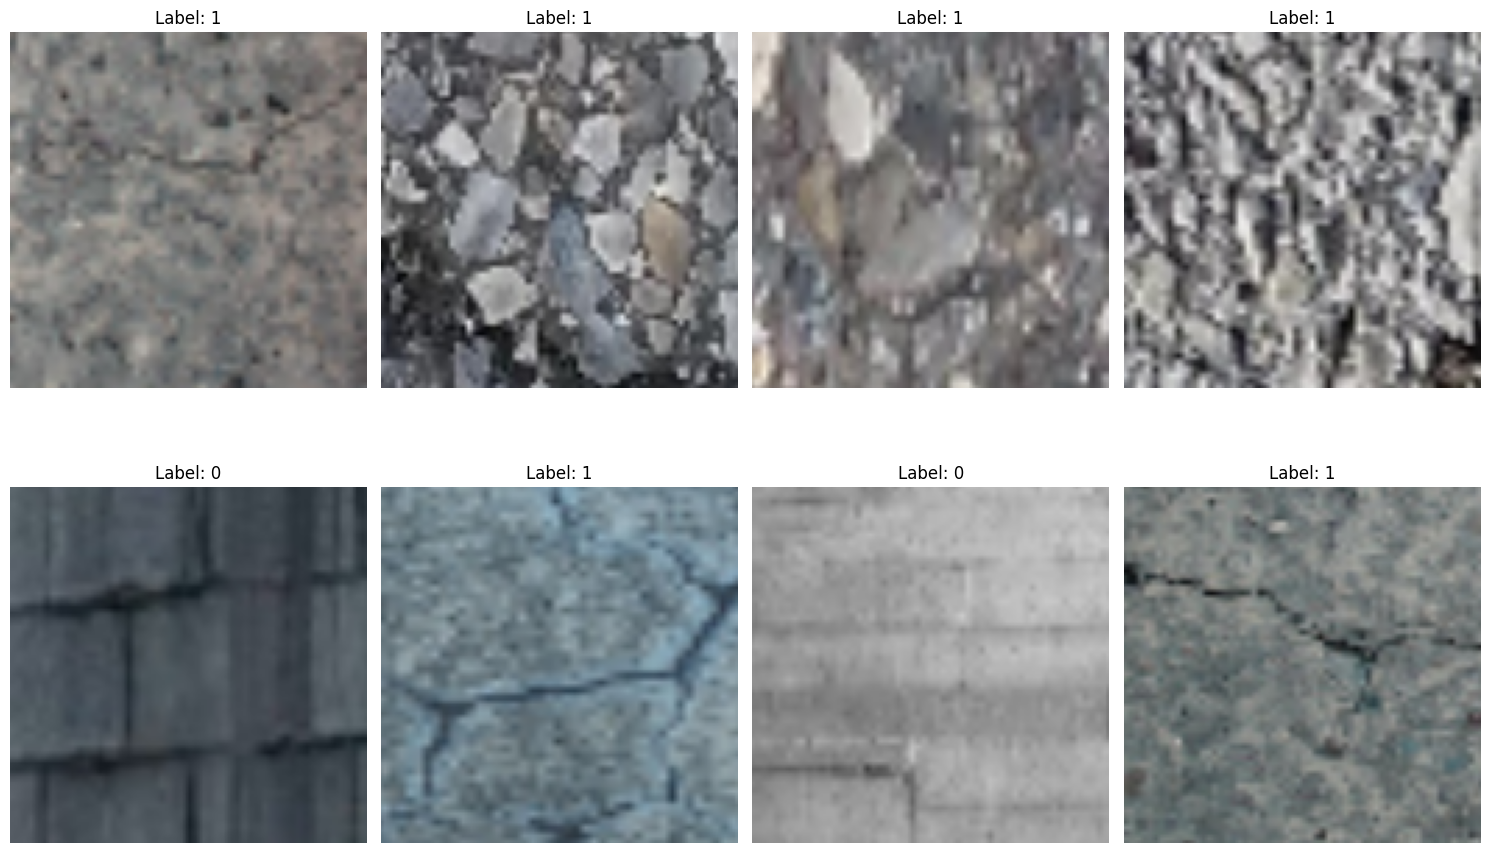

In [6]:
# Function to plot augmented images
def plot_augmented_images(generator, n_rows=2, n_cols=4):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 10))
    axs = axs.flatten()  # Flatten the array of axes for easier indexing

    # Generate one batch of images and labels
    images, labels = next(generator)  

    # Iterate through the images and display them
    for i in range(len(axs)):
        if i < len(images):  # Ensure we don't go out of bounds
            img = images[i]
            img = (img * 255).astype(np.uint8)

            axs[i].imshow(img)
            axs[i].set_title(f"Label: {int(labels[i])}")  # Convert label to int
            axs[i].axis('off')
        else:
            axs[i].axis('off')  # Turn off any remaining axes

    plt.tight_layout()
    plt.show()

# Plot the augmented images
plot_augmented_images(train_generator)

In [7]:
# Binary CNN

modelBinCNN = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')],
    name="BinCNN")

modelBinCNN.compile(
    optimizer=Adam(learning_rate=0.001),  # Adjust learning rate as needed
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), 'precision', 'recall']
)

c:\Users\mary9\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
modelBinCNN.summary()

Model: "BinCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Transfer learning

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

modelTransferSqueeze = Model(inputs=base_model.input, outputs=x, name="TransferSqueeze")

for layer in base_model.layers:
    layer.trainable = False

modelTransferSqueeze.compile(
    optimizer=Adam(learning_rate=0.001),  # Adjust learning rate as needed
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(), 'precision', 'recall']
)
# modelTransferSqueeze.summary()

In [10]:
# # U-Net

# inputs = Input((128, 128, 3))

# conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
# conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
# pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

# conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
# conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
# pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

# conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
# conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
# pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

# conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
# conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
# pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

# conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
# conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

# up6 = Conv2D(256, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
# merge6 = concatenate([conv4, up6], axis=3)
# conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge6)
# conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

# up7 = Conv2D(128, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
# merge7 = concatenate([conv3, up7], axis=3)
# conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge7)
# conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

# up8 = Conv2D(64, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
# merge8 = concatenate([conv2, up8], axis=3)
# conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge8)
# conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

# up9 = Conv2D(32, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
# merge9 = concatenate([conv1, up9], axis=3)
# conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge9)
# conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
# conv9 = Conv2D(2, (3, 3), activation='relu', padding='same')(conv9)
# conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)



# modelUNet = Model(inputs=[inputs], outputs=[conv10], name="U_Net")



# modelUNet.compile(
#     optimizer=Adam(learning_rate=0.001),  # Adjust learning rate as needed
#     loss='binary_crossentropy',
#     metrics=['accuracy', tf.keras.metrics.AUC(), 'precision', 'recall']
# )

# modelUNet.summary()

Training  

In [11]:
callbacks = [
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    TensorBoard(log_dir='logs')  # Logs for TensorBoard
]
callbacksUnet = [
    ModelCheckpoint('best_model_unet.keras', monitor='val_loss', save_best_only=True, mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    TensorBoard(log_dir='logs')  # Logs for TensorBoard
]

callbacksRes = [
    ModelCheckpoint('best_model_res.keras', monitor='val_loss', save_best_only=True, mode='min'),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    TensorBoard(log_dir='logs')  # Logs for TensorBoard
]

In [12]:
# train_images, val_images = train_test_split(train_generator, test_size=0.2, random_state=44)

# # Create new train and validation generators if needed
# train_generator, val_generator = create_generators(train_images, val_images)


In [13]:
# Fit the BinaryCNN
historyBin = modelBinCNN.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks,
    verbose=1
)
modelBinCNN.save('modelBinCNN.h5')

# Fit the ResNet transfer
historyRes = modelTransferSqueeze.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacksRes,
    verbose=1
)
modelTransferSqueeze.save('modelRes.h5')

# # Fit the U-net
# historyUnet = modelUNet.fit(
#     train_generator,
#     validation_data=val_generator,
#     epochs=50,
#     callbacks=callbacksUnet,
    # verbose=1
# )
# modelUNet.save('modelUNet.h5')


Epoch 1/50


c:\Users\mary9\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


601/601 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.8742 - auc: 0.7632 - loss: 0.3362 - precision: 0.8860 - recall: 0.9798

c:\Users\mary9\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


601/601 ━━━━━━━━━━━━━━━━━━━━ 143s 231ms/step - accuracy: 0.8743 - auc: 0.7633 - loss: 0.3361 - precision: 0.8860 - recall: 0.9798 - val_accuracy: 0.9188 - val_auc: 0.8873 - val_loss: 0.2764 - val_precision: 0.9190 - val_recall: 0.9945
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 143s 237ms/step - accuracy: 0.9224 - auc: 0.8786 - loss: 0.2415 - precision: 0.9357 - recall: 0.9779 - val_accuracy: 0.8893 - val_auc: 0.8437 - val_loss: 0.4245 - val_precision: 0.8876 - val_recall: 0.9996
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 139s 231ms/step - accuracy: 0.9163 - auc: 0.8762 - loss: 0.2365 - precision: 0.9306 - recall: 0.9769 - val_accuracy: 0.9341 - val_auc: 0.9046 - val_loss: 0.2183 - val_precision: 0.9432 - val_recall: 0.9836
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 141s 234ms/step - accuracy: 0.9327 - auc: 0.9027 - loss: 0.2015 - precision: 0.9422 - recall: 0.9836 - val_accuracy: 0.9210 - val_auc: 0.9050 - val_loss: 0.2304 - val_precision: 0.9220 - val_recall: 0.9933
Epoch 5/50
601/601 ━━━━━━━━

Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 338s 551ms/step - accuracy: 0.8675 - auc_1: 0.6101 - loss: 0.3835 - precision: 0.8675 - recall: 1.0000 - val_accuracy: 0.8716 - val_auc_1: 0.6571 - val_loss: 0.3589 - val_precision: 0.8716 - val_recall: 1.0000
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 325s 540ms/step - accuracy: 0.8701 - auc_1: 0.6755 - loss: 0.3590 - precision: 0.8701 - recall: 1.0000 - val_accuracy: 0.8716 - val_auc_1: 0.6938 - val_loss: 0.3786 - val_precision: 0.8716 - val_recall: 1.0000
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 320s 531ms/step - accuracy: 0.8667 - auc_1: 0.7137 - loss: 0.3539 - precision: 0.8667 - recall: 1.0000 - val_accuracy: 0.8716 - val_auc_1: 0.7210 - val_loss: 0.3513 - val_precision: 0.8716 - val_recall: 1.0000
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 320s 532ms/step - accuracy: 0.8738 - auc_1: 0.7245 - loss: 0.3394 - precision: 0.8738 - recall: 1.0000 - val_accuracy: 0.8716 - val_auc_1: 0.7435 - val_loss: 0.3477 - val_precision: 0.8716 - val_recall: 1.0000


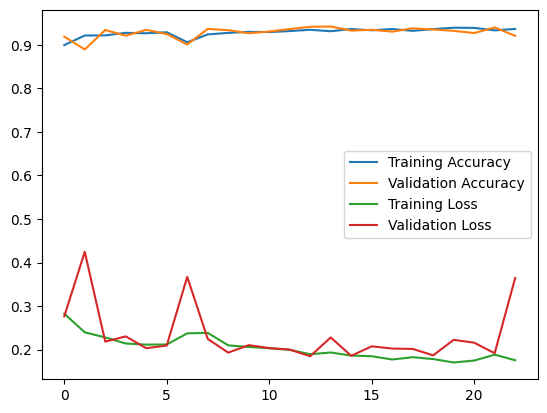

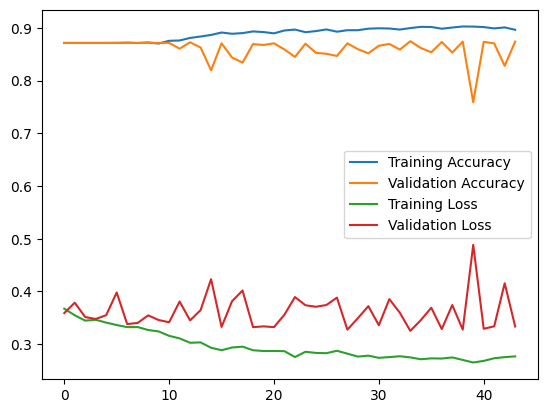

In [16]:
def plot_history(hist):
    plt.plot(hist.history['accuracy'], label='Training Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(hist.history['loss'], label='Training Loss')
    plt.plot(hist.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

plot_history(historyBin)
# plot_history(historyUnet)
plot_history(historyRes)

In [ ]:
from tensorflow.keras.models import load_model

# Load the best saved model
model = load_model('best_model.keras')

predictions = model.predict(new_data)


In [ ]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(val_generator)
predictions = (predictions > 0.5).astype("int32")
cm = confusion_matrix(val_generator.classes, predictions)
print(cm)


In [ ]:

for img, mask in zip(val_generator.filepaths, val_generator.classes):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    pred_mask = model.predict(np.expand_dims(img, axis=0))
    pred_mask = (pred_mask > 0.5).astype("uint8")
    cv2.imshow('Image', img)
    cv2.imshow('Predicted Mask', pred_mask)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [ ]:
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.applications import Xception
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
# from tensorflow.keras import backend as K

# def grad_cam(model, img, class_idx, layer_name):
#     class_output = model.output[:, class_idx]
#     conv_output = model.get_layer(layer_name).output
#     grads = K.gradients(class_output, conv_output)[0]
#     gradient_function = K.function([model.input], [conv_output, grads])
#     output, grads_val = gradient_function([img])
#     output, grads_val = output[0], grads_val[0]
#     weights = np.mean(grads_val, axis=(0, 1))
#     cam = np.dot(output, weights)
#     cam = cv2.resize(cam, (img.shape[1], img.shape[0]), cv2.INTER_LINEAR)
#     cam = np.maximum(cam, 0)
#     cam = cam / cam.max()
#     return cam

# # Example usage
# img_path = 'path_to_your_image.jpg'
# img = image.load_img(img_path, target_size=(128, 128))
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0) / 255.0

# preds = model.predict(img_array)
# class_idx = np.argmax(preds[0])
# layer_name = 'conv2d_3'  # Replace with the last convolutional layer name in your model

# cam = grad_cam(model, img_array, class_idx, layer_name)
# cam = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
# cv2.imshow('Grad-CAM', cam)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
